# Spatial Joins

The notebooks on [Spatial Relations](), [Spatial Operations]() and [Voronoi]() showed how we can use the [Shapely]() and [PySAL]() packages to analyse and create geometric features in space. But what about if we want to also analyse data associated with those geometric features?

For example, the `Cholera_Deaths.shp` shapefile [contains](https://github.com/jamesdamillington/john-snow/blob/main/README.md) the number of deaths due to Cholera reported at locations around Soho during the [1854 cholera outbreak](https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak). How can we compare the number of deaths reported by this datafile to the buffers and Thiessen polygons (voronoi) created in those other notebooks?

To do this we need to do a [spatial join](http://wiki.gis.com/wiki/index.php/Spatial_Join) of the deaths point data and the buffer/voronoi polygon data. A spatial join allows us to get attribute data from one spatial layer and transfer it to another layer based on their spatial relationship (in contrast to Pandas non-spatial joins which [merge](https://pandas.pydata.org/docs/user_guide/merging.html) DataFrames without use of spatial geometries). 

We can do spatial joins using [the `sjoin` method in GeoPandas](https://geopandas.org/mergingdata.html#spatial-joins) (which in turn draws on Shapely). In this notebook we will examine:
1. `sjoin` to find points within <a href="#buff">buffer polygons</a>
2. `sjoin` join to find points within <a href="#voronoi">voronoi polygons</a>
3. <a href="#comp">compare the results</a> of 1. and 2. using a-spatial (bar) plots 

## Essentials of Spatial Joins  <a id='notes'></a>
Spatial Joins rely on concepts from both [Spatial relations](https://en.wikipedia.org/wiki/Spatial_relation) and [non-spatial joining of DataFrames](https://pandas.pydata.org/docs/user_guide/merging.html).   

When doing a spatial join, we need to decide two things:
- what spatial relation are we going to use to do the join? (defined by the `op` argument)
- which type of join between the two DataFrames? (defined by the `how` argument)

Possible spatial relations we can use [with `sjoin` in GeoPandas are](https://geopandas.org/mergingdata.html#spatial-joins):
- `intersects`: The attributes will be joined if the boundary and interior of the object intersect in any way with the boundary and/or interior of the other object.
- `within`: The attributes will be joined if the object’s boundary and interior intersect only with the interior of the other object (not its boundary or exterior).
- `contains`: The attributes will be joined if the object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all.

These relations are identical to those with the same [Shapely function](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates) name (indeed, GeoPandas uses those exact functions itself). See the [Spatial Relations notebook]() for more on these. 

Possible types of join [are](https://geopandas.org/mergingdata.html#spatial-joins):
- `left`: use the index from the first (or left_df) geodataframe that you provide to sjoin; retain only the left_df geometry column
- `right`: use index from second (or right_df); retain only the right_df geometry column
- `inner`: use intersection of index values from both geodataframes; retain only the left_df geometry column

These determine which geometry is retained (i.e. from which DataFrame), and are the same as those used in [Pandas merge methods](https://pandas.pydata.org/docs/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra). 

## Setup

Import required libraries

In [1]:
import geopandas as gpd
import shapely

import matplotlib.pyplot as plt
import matplotlib as mpl   #for colour palette
  
from libpysal.cg import voronoi, voronoi_frames
import numpy as np
import pandas as pd 

Load data

In [2]:
pumps = gpd.read_file('../../data/csds/snow7/pumps.shp')      #point locations of pumps
blocks = gpd.read_file('../../data/dani/polys.shp')           #polygons delineating blocks of buildings
deaths = gpd.read_file('../../data/dani/Cholera_Deaths.shp')  #locations with at least one death (incl death count)

The deaths data provides point locations with at least one death, with a count of the deaths at that location. Let's check the data:

In [3]:
deaths.head()

,Id,Count,geometry
0,0,3,POINT (529308.741 181031.352)
1,0,2,POINT (529312.164 181025.172)
2,0,1,POINT (529314.382 181020.294)
3,0,1,POINT (529317.380 181014.259)
4,0,4,POINT (529320.675 181007.872)


In [4]:
deaths.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

The deaths dataset has the same CRS as the other data so we can readily use these datasets together, including for plotting:

<AxesSubplot:>

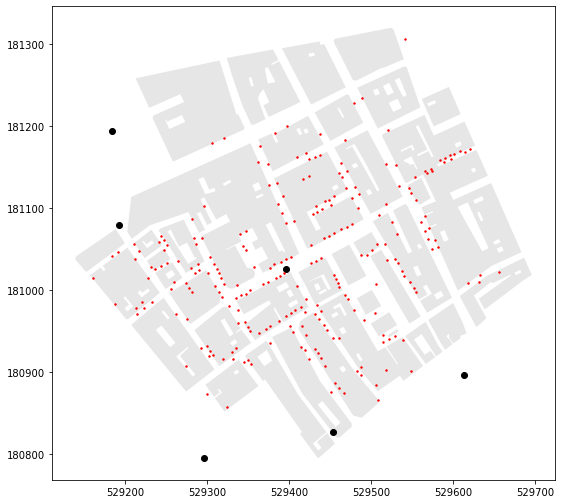

In [5]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
deaths.plot(ax=ax, color='red', markersize=2)

## Points in Buffer Polygons  <a id='buff'></a>

In other notebooks we have seen how to create buffers around the Soho pumps. Let's create these again here so that we can use them to examine how deaths were related to pumps:

In [6]:
pumps['buffer']=pumps.buffer(200)

<AxesSubplot:>

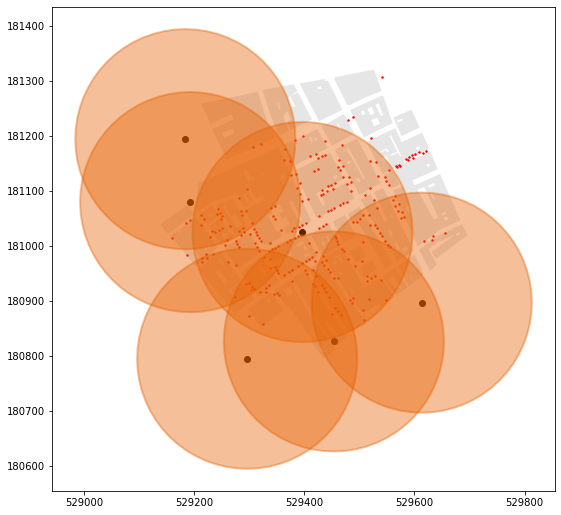

In [7]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['geometry'].plot(ax=ax, color='black')
deaths.plot(ax=ax, color='red', markersize=2)
pumps['buffer'].plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)

The code above creating the buffer polygons added those polygons to the `pumps` DataFrame. This means we now have _two_ columns containing geometries in the `pumps` DF:

In [8]:
pumps.head()

,ID,x,y,name,geometry,buffer
0,1,529396.539395,181025.063047,Broad St Pump,POINT (529396.539 181025.063),"POLYGON ((529596.539 181025.063, 529595.576 18..."
1,2,529192.537868,181079.391380,Great Malborough Pump,POINT (529192.538 181079.391),"POLYGON ((529392.538 181079.391, 529391.575 18..."
2,3,529183.739766,181193.735013,Ramilies Place Pump,POINT (529183.740 181193.735),"POLYGON ((529383.740 181193.735, 529382.777 18..."
3,5,529613.205238,180896.804121,Rupert St Pump,POINT (529613.205 180896.804),"POLYGON ((529813.205 180896.804, 529812.242 18..."
4,6,529453.585995,180826.353152,Brewer St Pump,POINT (529453.586 180826.353),"POLYGON ((529653.586 180826.353, 529652.623 18..."


Having two 'geometry' columns will confuse things when doing a spatial join. So, first we will create a new DF dropping the pumps point geometries to leave only the the buffers polygons geometries, plus all the other data columns:

In [9]:
buffers = pumps.loc[:, pumps.columns != 'geometry']
buffers

,ID,x,y,name,buffer
0,1,529396.539395,181025.063047,Broad St Pump,"POLYGON ((529596.539 181025.063, 529595.576 18..."
1,2,529192.537868,181079.391380,Great Malborough Pump,"POLYGON ((529392.538 181079.391, 529391.575 18..."
2,3,529183.739766,181193.735013,Ramilies Place Pump,"POLYGON ((529383.740 181193.735, 529382.777 18..."
3,5,529613.205238,180896.804121,Rupert St Pump,"POLYGON ((529813.205 180896.804, 529812.242 18..."
4,6,529453.585995,180826.353152,Brewer St Pump,"POLYGON ((529653.586 180826.353, 529652.623 18..."
5,8,529296.104419,180794.849037,Warwick St Pump,"POLYGON ((529496.104 180794.849, 529495.141 18..."


To do the spatial join, we use the [`sjoin` method](https://geopandas.org/reference/geopandas.sjoin.html) from GeoPandas. The `sjoin` method expects the DataFrames to each have a _geometry_ column. The `buffers` DF we just created no longer has a _geometry_ column, so we need to rename:

In [10]:
buffers=buffers.rename(columns = {'buffer':'geometry'})
buffers

,ID,x,y,name,geometry
0,1,529396.539395,181025.063047,Broad St Pump,"POLYGON ((529596.539 181025.063, 529595.576 18..."
1,2,529192.537868,181079.391380,Great Malborough Pump,"POLYGON ((529392.538 181079.391, 529391.575 18..."
2,3,529183.739766,181193.735013,Ramilies Place Pump,"POLYGON ((529383.740 181193.735, 529382.777 18..."
3,5,529613.205238,180896.804121,Rupert St Pump,"POLYGON ((529813.205 180896.804, 529812.242 18..."
4,6,529453.585995,180826.353152,Brewer St Pump,"POLYGON ((529653.586 180826.353, 529652.623 18..."
5,8,529296.104419,180794.849037,Warwick St Pump,"POLYGON ((529496.104 180794.849, 529495.141 18..."


Now we are ready to do our spatial join of the `deaths` and `buffers` dataframes. We want to know which deaths occured within which buffers. So, referring to <a href="#notes">the notes above</a>, we can use the following code:

In [11]:
deaths_in_buffers = gpd.sjoin(deaths, buffers, op='within', how='left')  #use left to get (point) geometry (from deaths)
deaths_in_buffers

,Id,Count,geometry,index_right,ID,x,y,name
0,0,3,POINT (529308.741 181031.352),0.0,1.0,529396.539395,181025.063047,Broad St Pump
0,0,3,POINT (529308.741 181031.352),1.0,2.0,529192.537868,181079.391380,Great Malborough Pump
1,0,2,POINT (529312.164 181025.172),0.0,1.0,529396.539395,181025.063047,Broad St Pump
1,0,2,POINT (529312.164 181025.172),1.0,2.0,529192.537868,181079.391380,Great Malborough Pump
2,0,1,POINT (529314.382 181020.294),0.0,1.0,529396.539395,181025.063047,Broad St Pump
...,...,...,...,...,...,...,...,...
248,0,1,POINT (529299.361 180873.185),4.0,6.0,529453.585995,180826.353152,Brewer St Pump
248,0,1,POINT (529299.361 180873.185),5.0,8.0,529296.104419,180794.849037,Warwick St Pump
249,0,1,POINT (529324.815 180857.949),0.0,1.0,529396.539395,181025.063047,Broad St Pump
249,0,1,POINT (529324.815 180857.949),4.0,6.0,529453.585995,180826.353152,Brewer St Pump


Note that we use the `within` relation, specifying `deaths` before `buffers` (as we want 'deaths within buffers).  We use `left` to retain the (point) geometry from the `deaths` DF. 

We could have asked the same question the other way around, to identify which buffers contain which deaths: 

In [12]:
buffers_contain_deaths = gpd.sjoin(buffers, deaths, op='contains', how='right')  #use right to get (point) geometry (from deaths)
buffers_contain_deaths

,index_left,ID,x,y,name,Id,Count,geometry
0,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,3,POINT (529308.741 181031.352)
0,1.0,2.0,529192.537868,181079.391380,Great Malborough Pump,0,3,POINT (529308.741 181031.352)
1,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,2,POINT (529312.164 181025.172)
1,1.0,2.0,529192.537868,181079.391380,Great Malborough Pump,0,2,POINT (529312.164 181025.172)
2,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,1,POINT (529314.382 181020.294)
...,...,...,...,...,...,...,...,...
248,4.0,6.0,529453.585995,180826.353152,Brewer St Pump,0,1,POINT (529299.361 180873.185)
248,5.0,8.0,529296.104419,180794.849037,Warwick St Pump,0,1,POINT (529299.361 180873.185)
249,0.0,1.0,529396.539395,181025.063047,Broad St Pump,0,1,POINT (529324.815 180857.949)
249,4.0,6.0,529453.585995,180826.353152,Brewer St Pump,0,1,POINT (529324.815 180857.949)


This second sjoined DF is identical to the first, but with a different order of columns. (Try playing with the `how` argument to see how you can return the polygon geometries)

Let's see how many records (points) have been returned in `deaths_in_buffers` DF:

In [13]:
deaths_in_buffers.shape

(548, 8)

But how many points are in the original deaths data?

In [14]:
deaths.shape

(250, 3)

So here we see that there are many more points (rows) in the `deaths_in_buffers` DF than in the `deaths` DF. This is because a death point can be wihin multiple buffer polygons, due to overlaps (check the visualisation above to check you understand this). If we want each point to be in a single polygon we will need to use Thiessen Polygons (which we'll look at below and compare). 

We can visualise deaths points in a given buffer. For example, we could plot points within the _Broad St Pump_ buffer in a different colour from all points:

<AxesSubplot:>

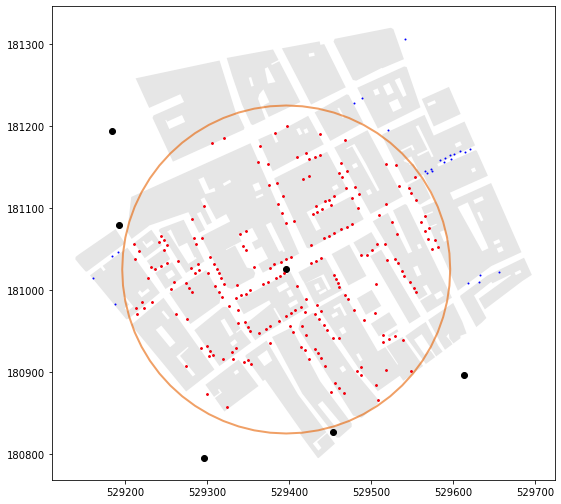

In [15]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

#plot all points (these will be over-laid)
deaths.plot(ax=ax, color='blue', markersize=1)

#subset DFs by name to plot only one polygon and points within
buffers[buffers['name']=='Broad St Pump'].plot(ax=ax, linewidth=2, 
                                               edgecolor='#e66101', facecolor='none', alpha=0.6)
deaths_in_buffers[deaths_in_buffers['name']=='Broad St Pump'].plot(ax=ax, color='red', markersize=3)

Or here, for the *Warwick St Pump*:

<AxesSubplot:>

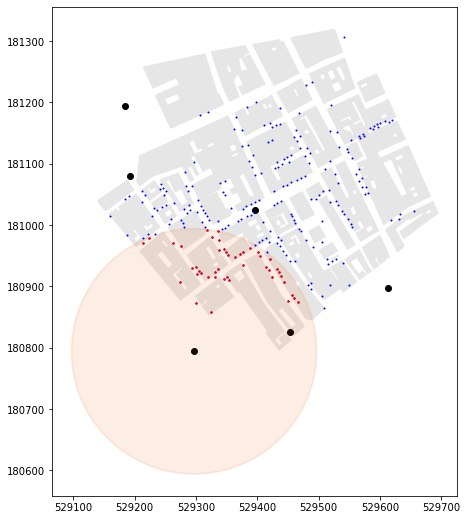

In [16]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')
buffers[buffers['name']=='Warwick St Pump'].plot(ax=ax, linewidth=2, 
                                               edgecolor='#e66101', facecolor='#e66101', alpha=0.1)
deaths.plot(ax=ax, color='blue', markersize=1)
deaths_in_buffers[deaths_in_buffers['name']=='Warwick St Pump'].plot(ax=ax, color='red', markersize=2)

Because we are working with a DataFrame, our analysis is now not restricted only to spatial visualisation. For example, let's count the number of deaths points in each buffer using the [`value_counts` Pandas method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html): 

In [17]:
deaths_in_buffers["name"].value_counts()

Broad St Pump            225
Great Malborough Pump     82
Brewer St Pump            80
Rupert St Pump            66
Warwick St Pump           46
Ramilies Place Pump       32
Name: name, dtype: int64

And we could plot a bar chart to compare the number of points between pump buffers:

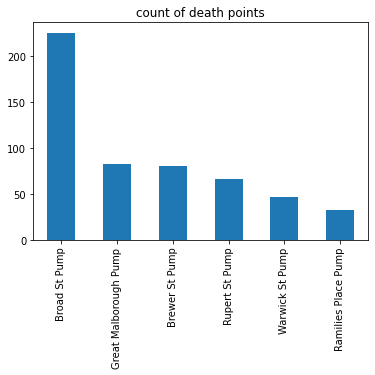

In [18]:
deaths_in_buffers["name"].value_counts().plot.bar(title="count of death points")
plt.show()

## Points in Voronoi  <a id='voronoi'></a>

Above we saw how a single death point could be located within multiple buffer polygons. To avoid this we could use Thiessen Polygons in a Voronoi diagram to ensure that points are located in only a single polygon (as Thiessen Polygons will never overlap). 

First we need to create our Thiessen Polygons (see the [Voronoi notebook]() for more on this):

In [19]:
points = np.vstack([pumps['x'], pumps['y']]).T  
regions_df, vertices_df = voronoi_frames(points, clip='none')

As we have created DataFrames (using the `_frames` function) we can add some useful information to the voronoi geometries (useful for labelling plots later):

In [20]:
regions_df['name'] = pumps['name']
vertices_df['name'] = pumps['name']
regions_df

,geometry,name
0,"POLYGON ((529355.796 180905.823, 529265.984 18...",Broad St Pump
1,"POLYGON ((-126296.896 -57664.076, 529265.984 1...",Great Malborough Pump
2,"POLYGON ((-166260.985 127625.654, 529319.694 1...",Ramilies Place Pump
3,"POLYGON ((811193.117 -457288.785, 927233.697 7...",Rupert St Pump
4,"POLYGON ((666206.189 -503176.740, 811193.117 -...",Brewer St Pump
5,"POLYGON ((-126296.896 -57664.076, 666206.189 -...",Warwick St Pump


Quick spatial visualisation to check this has worked: 

<AxesSubplot:>

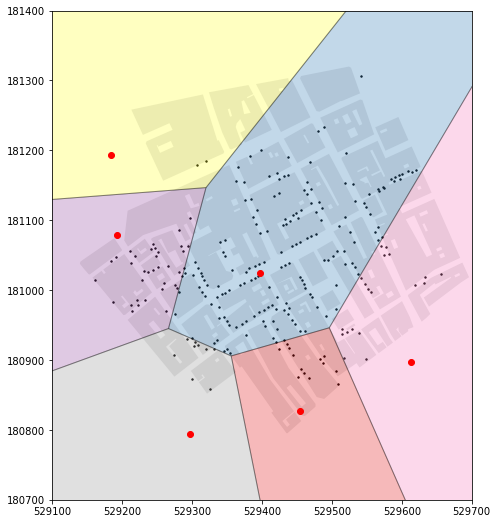

In [21]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.set_xlim(529100,529700)   #play with these values
ax.set_ylim(180700,181400)   #play with these values
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
deaths.plot(ax=ax, facecolor='black', markersize=2)
#use column here with a colourmap 
regions_df.plot(ax=ax, column='name', cmap='Set1', edgecolor='black', alpha=0.3)
vertices_df.plot(ax=ax, color='red')

It looks like are we now ready to do our spatial join. So, referring to <a href="#notes">the notes above</a>, we can use the following code:

In [22]:
deaths_in_voronoi = gpd.sjoin(deaths, regions_df, op='within', how='left')
deaths_in_voronoi

/home/james/anaconda3/envs/sds2020/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  """Entry point for launching an IPython kernel.


,Id,Count,geometry,index_right,name
0,0,3,POINT (529308.741 181031.352),0,Broad St Pump
1,0,2,POINT (529312.164 181025.172),0,Broad St Pump
2,0,1,POINT (529314.382 181020.294),0,Broad St Pump
3,0,1,POINT (529317.380 181014.259),0,Broad St Pump
4,0,4,POINT (529320.675 181007.872),0,Broad St Pump
...,...,...,...,...,...
245,0,3,POINT (529362.665 181156.058),0,Broad St Pump
246,0,2,POINT (529365.152 181176.129),0,Broad St Pump
247,0,1,POINT (529274.165 180907.313),5,Warwick St Pump
248,0,1,POINT (529299.361 180873.185),5,Warwick St Pump


We have successfully created a DataFrame, but note that we got a warning about the CRS of the 'right' DataFrame (`regions_df`). The warning implies that the DataFrame has no CRS. Let's check that:

In [23]:
regions_df.crs

We got no output. So let's force something to be printed:

In [24]:
print(regions_df.crs)

None


Now we can see no CRS is set for `regions_df`. Given that the last spatial visualisation looked good and the `deaths_in_voronoi` DF looks okay from a quick look, let's be safe and set the CRS to match the `deaths` DF CRS. 

Let's remind ourselves what that CRS is: 

In [25]:
deaths.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

And now set the CRS of `regions_df` using the epsg id:

In [26]:
regions_df= regions_df.set_crs(epsg=27700)

And check:

In [27]:
print(regions_df.crs)

epsg:27700


Good, now do the spatial join again:

In [28]:
deaths_in_voronoi = gpd.sjoin(deaths, regions_df, op='within', how='left')
deaths_in_voronoi

,Id,Count,geometry,index_right,name
0,0,3,POINT (529308.741 181031.352),0,Broad St Pump
1,0,2,POINT (529312.164 181025.172),0,Broad St Pump
2,0,1,POINT (529314.382 181020.294),0,Broad St Pump
3,0,1,POINT (529317.380 181014.259),0,Broad St Pump
4,0,4,POINT (529320.675 181007.872),0,Broad St Pump
...,...,...,...,...,...
245,0,3,POINT (529362.665 181156.058),0,Broad St Pump
246,0,2,POINT (529365.152 181176.129),0,Broad St Pump
247,0,1,POINT (529274.165 180907.313),5,Warwick St Pump
248,0,1,POINT (529299.361 180873.185),5,Warwick St Pump


Remember that for deaths in buffers the result of our `sjoin` was a DF with many more rows (points) than the original `deaths` DF. We can see here that we now have the same number of points (as hoped, given that Thiessen Polygons do not overlap):

In [29]:
print(deaths.shape)
print(deaths_in_voronoi.shape)

(250, 3)
(250, 5)


As above, let's plot for a single polygon and points within to visualise the new DF:

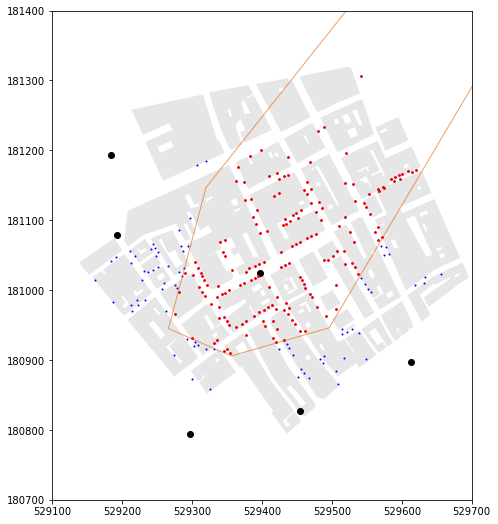

In [30]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

#plot all points (these will be over-laid)
deaths.plot(ax=ax, color='blue', markersize=1)

#subset DFs by name to plot only one polygon and points within
regions_df[regions_df['name']=='Broad St Pump'].plot(ax=ax, linewidth=1, 
                                               edgecolor='#e66101', facecolor='none', alpha=0.6)
deaths_in_voronoi[deaths_in_voronoi['name']=='Broad St Pump'].plot(ax=ax, color='red', markersize=3)



ax.set_xlim(529100,529700)   #play with these values
ax.set_ylim(180700,181400)   #play with these values

plt.show()

Because each point is now unique to each pump polygon, we could visualise all points coloured according to their nearest pump:

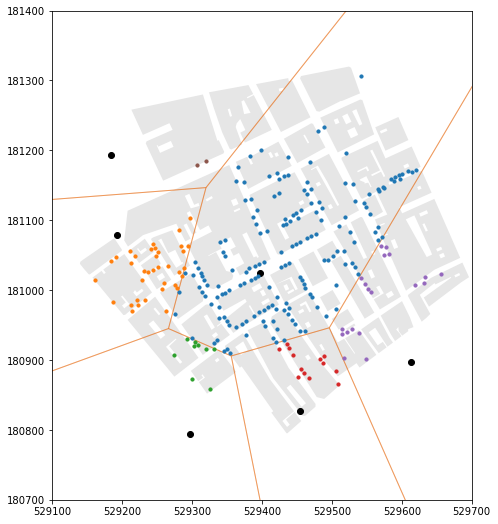

In [31]:
pumpNames = list(deaths_in_voronoi['name'].unique())

f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

regions_df.plot(ax=ax, linewidth=1, edgecolor='#e66101', facecolor='none', alpha=0.4)

#loop through pump names, plotting points with a different colour
for idx, name in enumerate(pumpNames):
    deaths_in_voronoi[deaths_in_voronoi['name']==name].plot(ax=ax,color=mpl.cm.tab10(idx), markersize=10)

ax.set_xlim(529100,529700)   #play with these values
ax.set_ylim(180700,181400)   #play with these values

plt.show()

And as above for buffers, because we are working with a DataFrame, our analysis is now not restricted only to spatial visualisation. For example, let's count the number of deaths point locations in each buffer using the [`value_counts` Pandas method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html): 

In [32]:
deaths_in_voronoi["name"].value_counts()

Broad St Pump            171
Great Malborough Pump     36
Rupert St Pump            19
Brewer St Pump            13
Warwick St Pump            9
Ramilies Place Pump        2
Name: name, dtype: int64

And we could plot a bar chart to compare the number of point locations between pump buffers:

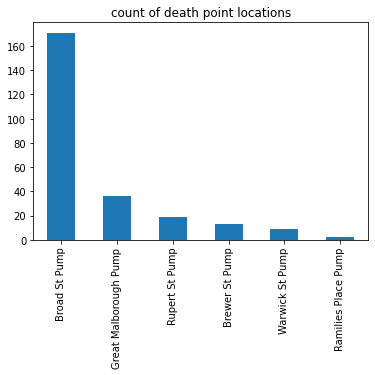

In [33]:
deaths_in_voronoi["name"].value_counts().plot.bar(title="count of death point locations")
plt.show()

## Comparison <a id='comp'></a>

We noted above that `sjoin` for buffers produced different output than for voronoi. Let's compare the differences. As we have joined the data in DataFrames we can use Pandas data manipulation and plotting methods. 

First, calculate DFs containing counts of the point locations in the polygons: 

In [34]:
vcounts = deaths_in_voronoi["name"].value_counts()
bcounts = deaths_in_buffers["name"].value_counts()

Now combine the DataFrames we've created using a **non-spatial** join (i.e. Pandas `merge`):

In [35]:
compareCounts = pd.merge(bcounts, vcounts, right_index = True,left_index = True)
compareCounts

,name_x,name_y
Broad St Pump,225,171
Great Malborough Pump,82,36
Brewer St Pump,80,13
Rupert St Pump,66,19
Warwick St Pump,46,9
Ramilies Place Pump,32,2


The DF that we have produced, does not have intutive column names. So let's rename:

In [36]:
compareCounts = compareCounts.rename(columns={
    'name_x':'buffers',
    'name_y':'voronoi'})
compareCounts

,buffers,voronoi
Broad St Pump,225,171
Great Malborough Pump,82,36
Brewer St Pump,80,13
Rupert St Pump,66,19
Warwick St Pump,46,9
Ramilies Place Pump,32,2


Now let's do a paired bar plot to compare the number of deaths points attributed to each pump by the two methods:

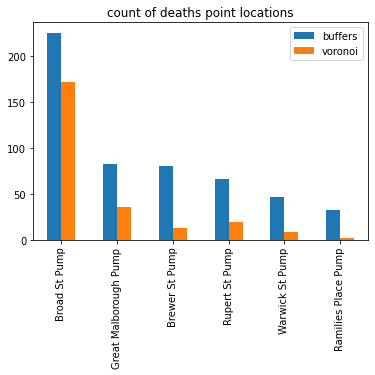

In [37]:
compareCounts.sort_values('buffers',ascending=False).plot.bar(title="count of deaths point locations")
plt.show()

So we can see the buffers polygons always have more deaths points within them than the voronoi polygons. This makes sense given that all pump buffers overlap at least one other buffer. 

This analysis has just been for the _number of point locations_ in the `deaths` DF. But the Cholera Deaths point data [are](https://bitbucket.org/darribas/reproducible_john_snow/src/master/data/README.txt):
>Points for each location of one or more deaths. Attribute value gives number of deaths at that location

This means the `deaths` DF also contains information about the _total number of people_ that died at each location. So we can also compare the total number of deaths attributed to each polygon by the points in the two different approaches. We do this by calculating the **sum** of the _Count_ columns (rather the count, as above): 

In [38]:
vdeaths = deaths_in_voronoi.groupby('name')['Count'].sum()
bdeaths = deaths_in_buffers.groupby('name')['Count'].sum()

Now create a single DF: 

In [39]:
compareSums = pd.merge(bdeaths,vdeaths,right_index = True,left_index = True)
compareSums = compareSums.rename(columns={
    'Count_x':'buffers',
    'Count_y':'voronoi'})
compareSums

,buffers,voronoi
name,,
Brewer St Pump,149,27
Broad St Pump,451,340
Great Malborough Pump,159,65
Ramilies Place Pump,61,5
Rupert St Pump,134,40
Warwick St Pump,74,12


And a bar plot now compares total deaths attributed to pumps between the two approaches: 

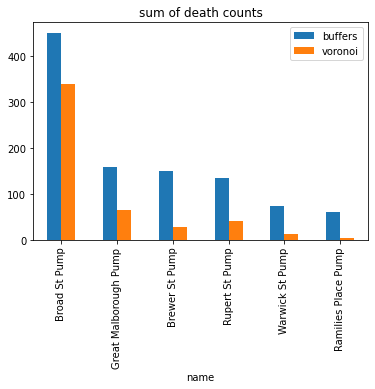

In [40]:
compareSums.sort_values('buffers',ascending=False).plot.bar(title="sum of death counts")
plt.show()

As for the number of point locations, we always have more deaths in buffers because some points are double-counted due to overlaps. 

We could check what the total number of death is in the original data:

In [41]:
deaths['Count'].sum()

489

And then see the sum for the points in polygons for the two different approaches:

In [42]:
compareSums.sum()

buffers    1028
voronoi     489
dtype: int64

We can see that Voronoi, because of no spatial overlap, ensures no double-counting of deaths.

## Further Activities

- Explore spatial joins for other geometries, for example:
    - polygons within polygons
    - lines intersects polygons 
- Try [other tutorials](https://kodu.ut.ee/~kmoch/geopython2018/lessons/L3/spatial-join.html) on spatial joins 

## Credits!

### Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).